#### Explore different methods of recommender systems.
#### Predict user ratings from movies data

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import pandasql
from sklearn.metrics import mean_squared_error

import surprise
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import NMF


np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
movies = pd.read_csv("movies.csv")
movies = pd.concat([movies, movies['genres'].str.get_dummies(sep='|')], axis = 1)

ratings = pd.read_csv("ratings.csv")

remove_movie_ids = movies[movies['genres']=='(no genres listed)']['movieId']
ratings = ratings[~ratings['movieId'].isin(remove_movie_ids)]
movies = movies[~movies['movieId'].isin(remove_movie_ids)]

ratings = ratings[:100000].drop('timestamp', axis =1)

#ratings = ratings.sample(n = 10000)

ratings.describe()

,userId,movieId,rating
count,100000.000000,100000.000000,100000.000000
mean,387.823880,20762.808270,3.584945
std,220.759075,38049.017578,1.041426
min,1.000000,1.000000,0.500000
25%,187.000000,1089.000000,3.000000
50%,406.000000,2717.000000,4.000000
75%,572.000000,8368.000000,4.000000
max,757.000000,206272.000000,5.000000


In [3]:
user_ratings = np.array(ratings.pivot_table(index='userId', columns='movieId', values = 'rating', fill_value=0))
user_ratings[:2]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [3.5, 0. , 0. , ..., 0. , 0. , 0. ]])

#### Exploratory Analysis

In [4]:
movies.movieId.count(), ratings.userId.nunique(), ratings.movieId.nunique()

(57361, 757, 9737)

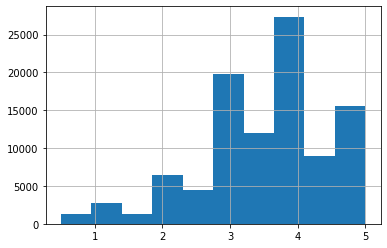

In [5]:
ratings.rating.hist()

Text(0.5, 1.0, 'Number of ratings per movie')

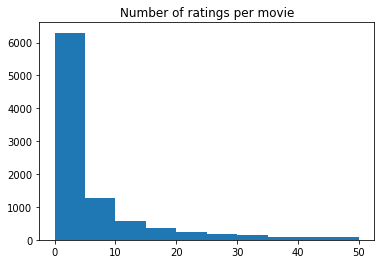

In [6]:
plt.hist(np.count_nonzero(user_ratings, axis = 0), range=[0,50])
plt.title("Number of ratings per movie")

Text(0.5, 1.0, 'Number of ratings per user')

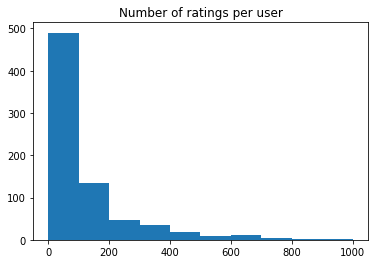

In [7]:
plt.hist(np.count_nonzero(user_ratings, axis = 1), range = [0, 1000])
plt.title("Number of ratings per user")

In [8]:
ratings_movies = ratings.merge(movies, how = 'inner',left_on='movieId', right_on='movieId' ).drop('(no genres listed)', axis =1)
ratings_movies[:2]

,userId,movieId,rating,title,genres,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,3,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [9]:
top_rated_movies = pandasql.sqldf("""SELECT title, count(*) as n_ratings, avg(rating) as avg_rating
                                  FROM ratings_movies 
                                  GROUP BY title 
                                  ORDER BY count(*) desc 
                                  LIMIT 20;""", globals())
top_rated_movies

,title,n_ratings,avg_rating
0,Forrest Gump (1994),370,4.072973
1,Pulp Fiction (1994),363,4.162534
2,"Shawshank Redemption, The (1994)",352,4.414773
3,"Silence of the Lambs, The (1991)",325,4.189231
4,"Matrix, The (1999)",315,4.169841
5,Jurassic Park (1993),300,3.705000
6,Star Wars: Episode IV - A New Hope (1977),292,4.183219
7,Schindler's List (1993),280,4.339286
8,Braveheart (1995),267,4.080524
9,Terminator 2: Judgment Day (1991),255,3.972549


#### Train - Test Split

In [10]:
user_ratings.shape

(757, 9737)

In [11]:
def fn_train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [12]:
train, test = fn_train_test_split(user_ratings)
train.shape, test.shape

((757, 9737), (757, 9737))

In [13]:
train[:2]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [3.5, 0. , 0. , ..., 0. , 0. , 0. ]])

In [14]:
test[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Content-Based Filtering
#### Use linear regression to predict ratings for a user based on their prior ratings.

In [15]:
user_1 = ratings_movies[ratings_movies.userId == 1]
user_1_train, user_1_test = train_test_split(user_1, test_size = 10)

X = user_1_train.drop(['userId','movieId','rating','title','genres'], axis =1)
Y = user_1_train['rating']
X.shape, Y.shape

((60, 19), (60,))

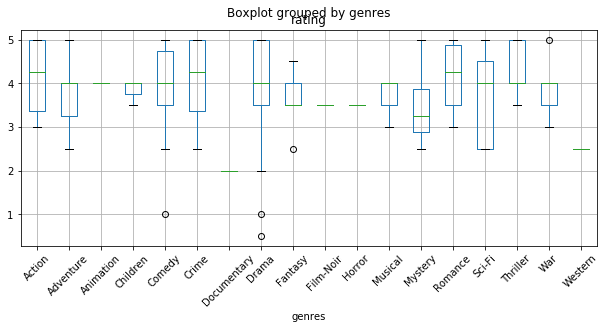

In [16]:
user_1 = user_1.assign(genres=ratings_movies['genres'].str.split('|')).explode('genres')
user_1.boxplot(column = 'rating',by = 'genres', rot = 45, figsize = (10,4))

In [17]:
reg = linear_model.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.23087632701939087

In [18]:
reg.coef_

array([ 2.43920838e-01,  7.02932934e-02,  3.50509899e-01,  8.99139633e-03,
       -1.02401482e-01,  2.28347049e-01, -1.67260689e+00,  2.10872980e-02,
       -2.51891583e-01, -1.07316958e+00, -1.93694192e-01, -2.77555756e-16,
       -5.57826598e-01, -5.77326577e-01,  6.93339468e-01, -1.32146068e-01,
        6.72215639e-01,  2.03503327e-01, -1.00835264e+00])

In [30]:
m_pred = movies[movies['movieId']==8360].drop(['title','genres','movieId','(no genres listed)'], axis = 1)
movies[movies['movieId'] ==8360].drop('(no genres listed)', axis =1)


,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
7734,8360,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...,0,1,1,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0


In [31]:
actual = user_1_test[user_1_test['movieId']==5269]['rating']
reg.predict(m_pred)[0] , actual

(4.135512870634496,
 1455    0.5
 Name: rating, dtype: float64)

#### Collaborative based filtering

In [32]:
cos_sim = cosine_similarity(train, train)
cos_sim[:4,:4]

array([[1.        , 0.02140913, 0.05584666, 0.02534235],
       [0.02140913, 1.        , 0.17422638, 0.18757172],
       [0.05584666, 0.17422638, 1.        , 0.34925795],
       [0.02534235, 0.18757172, 0.34925795, 1.        ]])

In [33]:
pear_sim = np.corrcoef(train)
pear_sim[:4,:4]

array([[1.        , 0.01211881, 0.03792086, 0.01441314],
       [0.01211881, 1.        , 0.14867845, 0.17255315],
       [0.03792086, 0.14867845, 1.        , 0.32611198],
       [0.01441314, 0.17255315, 0.32611198, 1.        ]])

In [34]:
pear_sim_item = np.corrcoef(train, rowvar = False)
pear_sim_item[1,:]

array([0.18086014, 1.        , 0.129287  , ..., 0.10941072, 0.10941072,
       0.07475636])

In [35]:
train.T.shape

(9737, 757)

In [36]:
def predict_rating(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[np.nonzero(actual)].flatten()
    actual = actual[np.nonzero(actual)].flatten()
    return mean_squared_error(pred, actual)


In [37]:
item_prediction = predict_rating(train, pear_sim_item, kind='item')
user_prediction = predict_rating(train, pear_sim, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
# print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 10.724472883938702


In [38]:
np.around(user_prediction,1)

array([[1.1, 0.3, 0.1, ..., 0. , 0. , 0. ],
       [1.6, 0.5, 0.3, ..., 0. , 0. , 0. ],
       [1.5, 0.4, 0.1, ..., 0. , 0. , 0. ],
       ...,
       [1.3, 0.4, 0.1, ..., 0. , 0. , 0. ],
       [1.5, 0.5, 0.2, ..., 0. , 0. , 0. ],
       [1.5, 0.6, 0.3, ..., 0. , 0. , 0. ]])

In [39]:
np.around(user_prediction[np.nonzero(test)].flatten(),1), test[np.nonzero(test)].flatten()

(array([0.2, 0.5, 0. , ..., 0.9, 0.4, 0.3]),
 array([5. , 2.5, 4. , ..., 3. , 3.5, 4. ]))

In [40]:
def predict_topk(ratings, similarity, kind='user', k=10):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred


pred = predict_topk(train, pear_sim, kind='user', k=10)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

# pred = predict_topk(train, pear_sim_item, kind='item', k=30)
# print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))


/home/prajakta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/home/prajakta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k User-based CF MSE: 10.005176214240803


#### NMF

In [41]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[["userId","movieId","rating"]], reader=reader)
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [42]:
def rmse_vs_factors(algorithm, data):  
  rmse_algorithm = []
  
  for k in range(1, 40, 1):
    algo = algorithm(n_factors = k)
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

rmse_nmf = rmse_vs_factors(NMF, data)

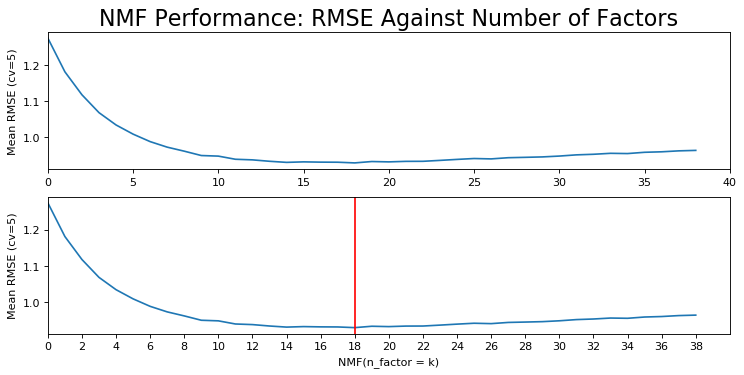

In [43]:
def plot_rmse(rmse, algorithm):
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,40)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,40)
  plt.xticks(np.arange(0, 40, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

plot_rmse(rmse_nmf,"NMF")

### Cold Start

In [44]:
pd.set_option('display.max_columns', None)
ratings_movies[:1]

,userId,movieId,rating,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0


In [45]:
top_movies_genre = pandasql.sqldf("""SELECT action, adventure,Animation,Children,Comedy,Crime,Documentary, Drama, Fantasy,
                                     Horror,IMAX,Musical,Mystery
                                    , count(*) as n_ratings, avg(rating) as avg_rating
                                  FROM ratings_movies 
                                  GROUP BY action, adventure,Animation,Children,Comedy,Crime,Documentary, Drama, Fantasy,
                                     Horror,IMAX,Musical,Mystery 
                                  HAVING count(*) > 30
                                  ORDER BY avg(rating) desc 
                                  LIMIT 20;""", globals())

top_movies_genre
#ratings_movies.groupby('userId').apply(lambda group: group.sample(10)).reset_index(drop = True)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,IMAX,Musical,Mystery,n_ratings,avg_rating
0,1,1,1,0,0,0,0,1,1,0,0,0,0,56,4.276786
1,1,0,0,0,0,1,0,1,0,0,1,0,1,165,4.242424
2,0,0,1,1,0,0,0,1,1,0,0,0,0,39,4.230769
3,0,0,1,0,0,0,0,1,1,0,0,0,0,32,4.156250
4,0,0,1,0,0,0,0,1,0,0,0,0,0,83,4.126506
5,1,0,0,0,0,1,0,1,0,0,1,0,0,193,4.072539
6,0,0,1,0,0,0,0,0,0,0,0,0,0,128,4.042969
7,0,0,1,1,1,1,0,0,0,0,0,0,0,101,4.039604
8,0,0,0,0,0,1,0,0,0,0,0,0,1,821,4.034105
9,0,1,0,1,0,0,0,0,1,0,0,1,0,103,4.000000
